In [1]:
%%time
# %load_ext autoreload
# %autoreload 2

import os
from itertools import combinations
from itertools import chain

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt

import fitz
import helper as hp

METRICS = [
    'f1_macro',
    'f1_micro',
    'f1_weighted',
    'accuracy',
    'balanced_accuracy'
]
PATH_PREDICT = 'marked_pdf/predict/'
PATH_REGEX = 'marked_pdf/regex/'

CPU times: user 4.4 s, sys: 804 ms, total: 5.21 s
Wall time: 4.99 s


## Carrega os dados em DataFrames e os rotula

In [2]:
%%time
file_lis = ['pdf/'+i for i in os.listdir('pdf') if i.endswith('.pdf')]
file_data = {}

cond = lambda x: len(x[4]) > 40 and '\n' in x[4]
for fname in file_lis:
    doc = fitz.open(fname)
    blocks = list(
        chain(
            *[ [(*i, pnum) for i in p.getTextBlocks() if cond(i)]
              for (pnum, p) in enumerate(doc)]
        )
    )
    pars = [i[4] for i in blocks]
    file_data[fname] = pd.DataFrame({
        'text': pars,
        'pnum':[int(i[-1]) for i in blocks],
        'x0': [i[0] for i in blocks],
        'y0': [i[1] for i in blocks],
        'x1': [i[2] for i in blocks],
        'y1': [i[3] for i in blocks],
        'y': map(hp.has_act, pars)
    })


CPU times: user 20.9 s, sys: 259 ms, total: 21.1 s
Wall time: 21.3 s


pdf/DODF 064 03-04-2020 INTEGRA.pdf
	f1: 0.85, acc: 0.96
pdf/DODF 228 03-12-2018 INTEGRA.pdf
	f1: 0.92, acc: 0.99
pdf/DODF 015 22-01-2019 INTEGRA.pdf
	f1: 0.96, acc: 1.00


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/DODF Seção 1 29-10-2001.pdf
	f1: 0.00, acc: 1.00
pdf/par_spans2.pdf
	f1: 1.00, acc: 1.00
pdf/DODF 081 30-04-2020 INTEGRA.pdf
	f1: 1.00, acc: 1.00
pdf/DODF 001 02-01-2019 INTEGRA.pdf
	f1: 1.00, acc: 1.00
pdf/DODF Seção 2 1-11-2001.pdf
	f1: 0.40, acc: 0.96
pdf/DODF Seção2 04-11-2002.pdf
	f1: 0.74, acc: 0.89


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/DODF 063 02-05-2020 EDICAO EXTRA.pdf
	f1: 0.00, acc: 1.00


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/DODF Seção1 04-11-2002.pdf
	f1: 0.00, acc: 1.00
pdf/DODF 062 02-04-2019 INTEGRA.pdf
	f1: 0.88, acc: 0.97
pdf/par_spans_filtered.pdf
	f1: 1.00, acc: 1.00


/home/leomaffei/.pyenv/versions/3.8.1/envs/pesquisa-unb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


pdf/DODF Seção 1 1-11-2001.pdf
	f1: 0.00, acc: 1.00
pdf/par_lines2.pdf
	f1: 1.00, acc: 1.00
CPU times: user 6min 45s, sys: 811 ms, total: 6min 46s
Wall time: 1min 8s


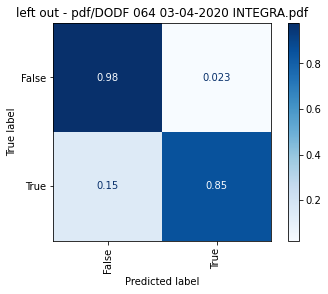

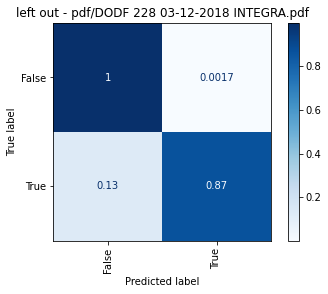

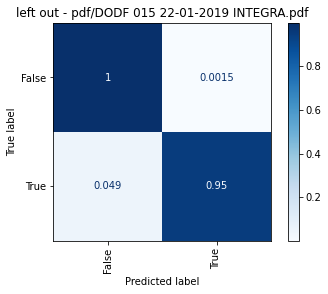

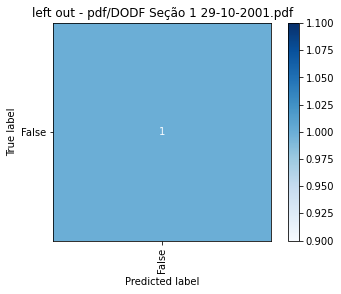

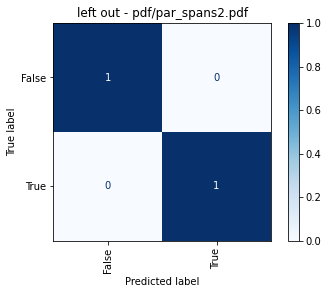

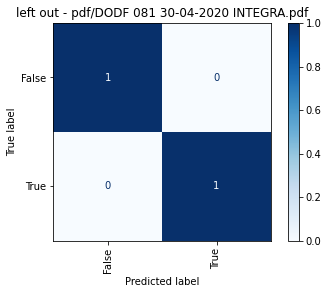

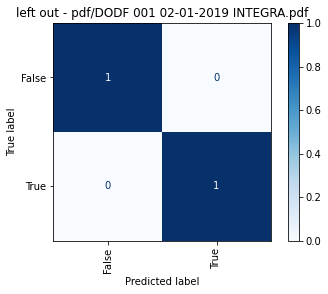

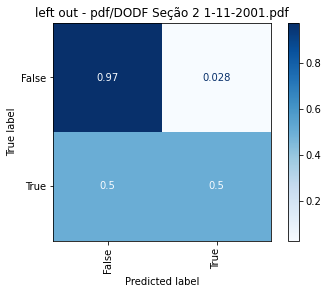

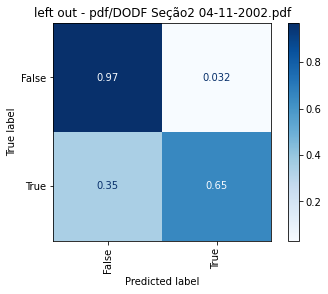

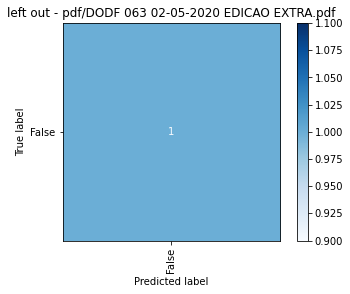

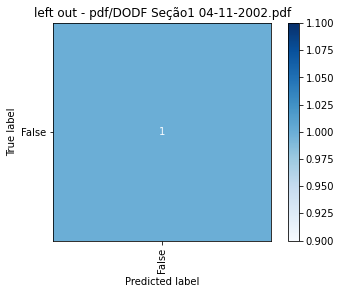

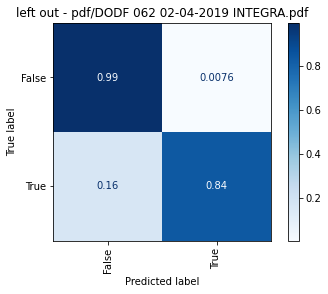

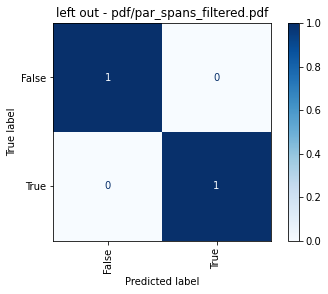

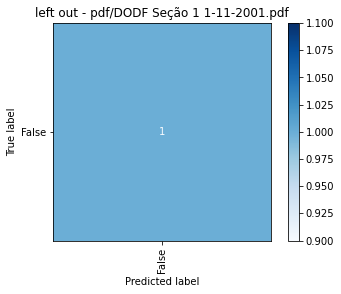

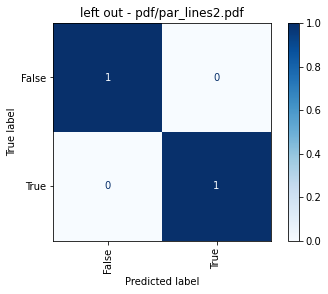

In [3]:
%%time
combs = combinations(file_data, len(file_data) - 1)

pipes = {}
preds = {}
dfs = {}

all_keys = set(file_data)
for c in combs:
    pipe = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('model', xgb.XGBClassifier(
            objective='multi:softprob',
            random_state=42,
            num_class=2
        ))
    ])    
    
    df = pd.concat(map(lambda x: file_data[x], c))
    diff = list(all_keys - set(c))
    out = diff[0]
    pipe.fit(df.text, df.y);
    
    pipes[out] = pipe
    dfs[out] = file_data[out].text
    preds[out] = pipe.predict(file_data[out].text)
    df = file_data[out]
    X,y = df.text, df.y
    disp = plot_confusion_matrix(pipe, X, y,
                            cmap=plt.cm.Blues,
                            normalize='true',
                            xticks_rotation='vertical',
                            )
    f1 = f1_score(y, preds[out])
    acc = accuracy_score(y, preds[out])
    print(out)
    print(f'\tf1: {f1:.2f}, acc: {acc:.2f}')
    disp.ax_.set_title(f'left out - {out}')

## Dump predictions to csv and marked PDFs

In [4]:
%%time
def dump_predict(lis, dist_dir, c=(.23, .41, .88)):
    for fname in lis:    
        doc = fitz.open(fname)
        df = file_data[fname]
        clf = pipes[fname]
        X, y = df['text'], df['y']
        predict = clf.predict(X)
        trues = df[predict == True]
        [doc[int(i.pnum)].drawRect(i[2:6], color=c, width=1)
            for i in trues.iloc];
        doc.save(dist_dir + fname.split('/')[-1][:-4] + '_predict.pdf');

def dump_regex(lis, dist_dir, c=(0, .5, .26)):
    for fname in lis:    
        doc = fitz.open(fname)
        df = file_data[fname]
        clf = pipes[fname]
        trues = df[df.y == True]
        if not any(trues):
            print("skip", fname)
        [doc[int(i.pnum)].drawRect(i[2:6], color=c, width=1)
            for i in trues.iloc];
        doc.save(dist_dir + fname.split('/')[-1][:-4] + '_regex.pdf');

def dump_csv():
    def pdf_csv(s):
        return s.split('/')[-1][:-3]+'csv'

    for fname in file_lis:    
        df = file_data[fname]
        prediction = preds[fname]

        df.to_csv(PATH_REGEX[:-1] + '_csv/' + pdf_csv(fname), index=False)
        pd.concat([df.iloc[:, :-1], pd.Series(prediction, name='y')], axis=1).to_csv(
            PATH_PREDICT[:-1] + '_csv/' + pdf_csv(fname), index=False
        )
dump_regex(file_lis, PATH_REGEX)
dump_predict(file_lis, PATH_PREDICT)
dump_csv()

CPU times: user 4.91 s, sys: 470 ms, total: 5.38 s
Wall time: 3.31 s
